# Google Analytics Customer Revenue Prediction
The goal is to predict revenue per customer thus allowing the marketing team to make better decisions with the aim of maximizing revenue.

### Data
 The datasat comes from Google Analytics and refers to one of google stores (https://your.googlemerchandisestore.com/).  
 Each row in the dataset is one visit to the store.  
 transactionRevenue contains the revenue information we are trying to predict.  

### Data fields
    fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
    channelGrouping - The channel via which the user came to the Store.
    date - The date on which the user visited the Store.
    device - The specifications for the device used to access the Store.
    geoNetwork - This section contains information about the geography of the user.
    sessionId - A unique identifier for this visit to the store.
    socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
    totals - This section contains aggregate values across the session.
    trafficSource - This section contains information about the Traffic Source from which the session originated.
    visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
    visitNumber - The session number for this user. If this is the first session, then this is set to 1.
    visitStartTime - The timestamp (expressed as POSIX time).


## Cross-industry standard process for data mining (CRISP)
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/1920px-CRISP-DM_Process_Diagram.png" width="400" align="left">

### References 
- json flattening - https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields  
- feature selection - https://www.kaggle.com/smasar/tutorial-preprocessing-processing-evaluation  
- EDA - https://www.kaggle.com/pavansanagapati/simple-exploration-lgbm-model-lb-1-4221   
- Model - https://www.kaggle.com/ogrellier/user-level-lightgbm-lb-1-4480/code
- Overview - https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue

In [22]:
import datetime
import os
import gc
import json
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns

print(os.listdir("../input"))

from contextlib import contextmanager
def timer(title=""):
    start = time()
    yield
    print("{} done in {:.0f}s".format(title, str(timedelta(seconds=time()-start))))

['train.csv', 'sample_submission.csv', 'test.csv']


### Data Preparation

In [37]:
#flattening json columns, based on kernel https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields
def load_df(path, nrows):
    JSON_COLUMNS = ["device", "geoNetwork", "totals", "trafficSource"]
    df = pd.read_csv(path,
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={"fullVisitorId": "str"}, #you must load the Id's as strings in order for all Id's to be properly unique
                     nrows=nrows)
    print(df["fullVisitorId"].unique().shape)
    for column in JSON_COLUMNS:
        print(column)
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [column + "_" + subcolumn for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [38]:
nrows = 50000
df_train = load_df("../input/train.csv", nrows)
df_test = load_df("../input/test.csv", nrows)

(45416,)
device
geoNetwork
totals
trafficSource
(44566,)
device
geoNetwork
totals
trafficSource


In [39]:
#merging datasets to apply same transformations
nrow_train = df_train.shape[0]
nrow_test = df_test.shape[0]
train_y = np.log1p(df_train["totals_transactionRevenue"].astype('float').fillna(0))
ids_train = df_train["fullVisitorId"]
ids_test = df_test["fullVisitorId"]
df = pd.concat((df_train, df_test), sort=False).reset_index(drop=True)

del df_train, df_test
gc.collect()

71

In [40]:
print(df.shape)
print(df.columns)
print(df.info())
df.head()

(100000, 54)
Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device_browser', 'device_browserSize', 'device_browserVersion',
       'device_deviceCategory', 'device_flashVersion', 'device_isMobile',
       'device_language', 'device_mobileDeviceBranding',
       'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName',
       'device_mobileDeviceModel', 'device_mobileInputSelector',
       'device_operatingSystem', 'device_operatingSystemVersion',
       'device_screenColors', 'device_screenResolution', 'geoNetwork_city',
       'geoNetwork_cityId', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_metro',
       'geoNetwork_networkDomain', 'geoNetwork_networkLocation',
       'geoNetwork_region', 'geoNetwork_subContinent', 'totals_bounces',
       'totals_hits', 'totals_newVisits', 'totals_pageviews',
       'totals_trans

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,device_browserVersion,device_deviceCategory,device_flashVersion,device_isMobile,device_language,device_mobileDeviceBranding,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_mobileDeviceModel,device_mobileInputSelector,device_operatingSystem,device_operatingSystemVersion,device_screenColors,device_screenResolution,geoNetwork_city,geoNetwork_cityId,geoNetwork_continent,geoNetwork_country,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_networkLocation,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_transactionRevenue,totals_visits,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available 

In [41]:
#formatting dates
df["date"] = pd.to_datetime(df["date"],format="%Y%m%d")
df["visitStartTime"] = pd.to_datetime(df["visitStartTime"],unit='s')

#https://pandas.pydata.org/pandas-docs/stable/api.html#datetimelike-properties
df["month"] = df["date"].dt.month
df["dayofweek"] = df["date"].dt.dayofweek
df["day"] = df["date"].dt.day
df.drop(columns=["date"], inplace=True)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


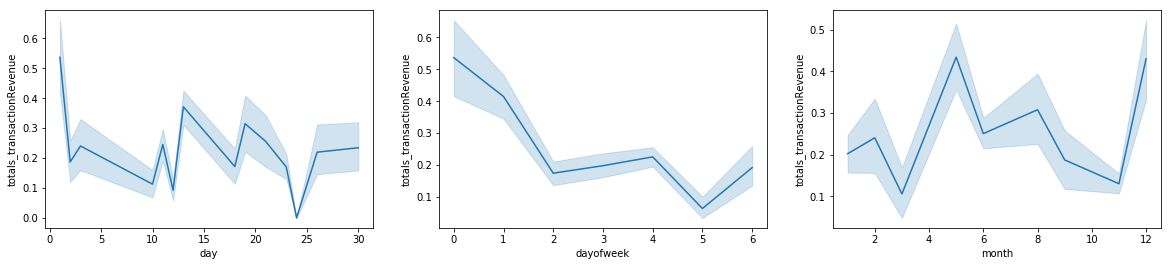

In [42]:
fig, ax = plt.subplots(1,3, figsize=(20,4))
sns.lineplot(x="day", y=train_y, data=df[:nrow_train], ax=ax[0])
sns.lineplot(x="dayofweek", y=train_y, data=df[:nrow_train], ax=ax[1])
sns.lineplot(x="month", y=train_y, data=df[:nrow_train], ax=ax[2])
fig.show()

In [43]:
#looking at the information contained in each feature, the closer to 0 the least information
def entropy_feats(df):
    entropy_0 = []
    for col in df.columns.tolist():
        p_data = df[col].value_counts()/len(df) #proportion of each feature
        entropy_value = sc.stats.entropy(p_data)
        if entropy_value == 0:
            entropy_0.append(col)
    return entropy_0

In [44]:
cols_entropy = entropy_feats(df)
df = df.drop(columns=cols_entropy)
print("Removed ", len(cols_entropy), " columns with constant values")

Removed  23  columns with constant values


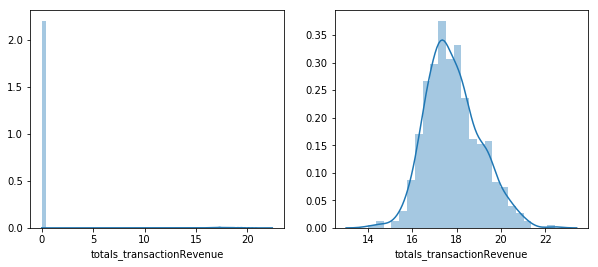

In [45]:
fig, ax =plt.subplots(1,2, figsize=(10,4))
sns.distplot(train_y, ax=ax[0])
sns.distplot(train_y[train_y != 0],  ax=ax[1])
fig.show()

### Modeling

In [46]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [47]:
#encoding categorical variables
drop_columns = ["fullVisitorId", "sessionId", "visitId", "visitStartTime", "totals_transactionRevenue"]
df = df.drop(columns=drop_columns)

cat_columns = [col for col in df.columns if df[col].dtype in ["object", "bool"]]

for col in cat_columns:
    le = LabelEncoder()
    train_vals = list(df[col].values.astype(str))
    le.fit(train_vals)
    df[col] = le.transform(train_vals)    
df.head()

,channelGrouping,visitNumber,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_hits,totals_pageviews,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,month,dayofweek,day
0,4,1,7,0,0,14,134,3,173,0,6299,98,21,0,0,43,2,4972,6,3,3,5,5,1040,57,9,4,2
1,4,1,11,0,0,6,320,5,9,54,1720,230,1,0,0,43,2,4972,6,3,3,5,5,1040,57,9,4,2
2,4,1,7,0,0,14,164,4,158,0,6553,51,19,0,0,43,2,4972,6,3,3,5,5,1040,57,9,4,2
3,4,1,32,0,0,5,320,3,78,54,6553,230,16,0,0,43,2,4972,6,3,3,162,5,1040,57,9,4,2
4,4,2,7,1,1,1,320,4,179,54,6553,230,13,0,0,43,2,4972,6,3,3,5,5,1040,57,9,4,2


In [48]:
#final sets
train_X = df[:nrow_train]
test_X = df[nrow_train:]

del df
gc.collect()

14863

In [61]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

#https://www.kaggle.com/sishihara/simple-lightgbm-kfold
#https://www.kaggle.com/ogrellier/user-level-lightgbm-lb-1-4480/code
def base_model(train_X, train_y, test_X):
    folds = KFold(n_splits=5, shuffle=True, random_state=2018)

    oof_preds = np.zeros(train_X.shape[0])
    sub_preds = np.zeros(test_X.shape[0])

    lgb_params = {"n_estimators": 2000, "learning_rate":0.03, "objective":'regression',"num_leaves":144, "max_depth":13,
              "bagging_fraction" : 0.8, "bagging_freq" : 5, "feature_fraction" : 0.9, "bagging_seed": 2018}

    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_X)):
        trn_x, trn_y = train_X.iloc[trn_idx], train_y.iloc[trn_idx]
        val_x, val_y = train_X.iloc[val_idx], train_y.iloc[val_idx]
        print(trn_x.shape, trn_y.shape, val_x.shape, val_y.shape)
        model = lgb.LGBMRegressor(**lgb_params)
        model.fit(trn_x, trn_y, eval_set= [(trn_x, trn_y), (val_x, val_y)], eval_metric="rmse", early_stopping_rounds=150, verbose=0)

        curr_oof_preds = model.predict(val_x, num_iteration=model.best_iteration_)          
        oof_preds[val_idx] = curr_oof_preds[curr_oof_preds < 0] = 0 #revenue can only be >0
                                           
        curr_sub_preds = model.predict(test_X, num_iteration=model.best_iteration_)
        curr_sub_preds[curr_sub_preds < 0] = 0
        sub_preds += curr_sub_preds / folds.n_splits #revenue can only be >0
                                           
        print('Fold %2d RSME : %.5f' % (n_fold + 1, rmse(val_y, oof_preds[val_idx])))
    print('Full RSME score %.5f' % rmse(train_y, oof_preds))
    return model, oof_preds, sub_preds

In [63]:
model, val_preds, test_preds = base_model(train_X, train_y, test_X)

(40000, 28) (40000,) (10000, 28) (10000,)
Fold  1 RSME : 2.15283
(40000, 28) (40000,) (10000, 28) (10000,)
Fold  2 RSME : 1.96648
(40000, 28) (40000,) (10000, 28) (10000,)
Fold  3 RSME : 1.89239
(40000, 28) (40000,) (10000, 28) (10000,)
Fold  4 RSME : 2.18790
(40000, 28) (40000,) (10000, 28) (10000,)
Fold  5 RSME : 1.97947
Full RSME score 2.03902


First 50k rows:   
    - Full RSME score: 2.03902  
Public LB:  
    - Full RSME score: 1.4945

In [64]:
val_pred_df = pd.DataFrame({"fullVisitorId": ids_train})
val_pred_df["transactionRevenue"] = train_y.values
val_pred_df["PredictedRevenue"] = np.expm1(val_preds)

val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(rmse(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values)))

0.3489101751071071


In [65]:
sub_df = pd.DataFrame({"fullVisitorId": ids_test})
sub_df["PredictedLogRevenue"] = np.expm1(test_preds)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.head()

,fullVisitorId,PredictedLogRevenue
0,0000059488412965267,0.002297
1,0000118334805178127,0.024995
2,0000174453501096099,0.002658
3,0000593255797039768,0.935354
4,0000955020478109523,0.006590


In [ ]:
sub_df.to_csv("baseline_lgb.csv", index=False)

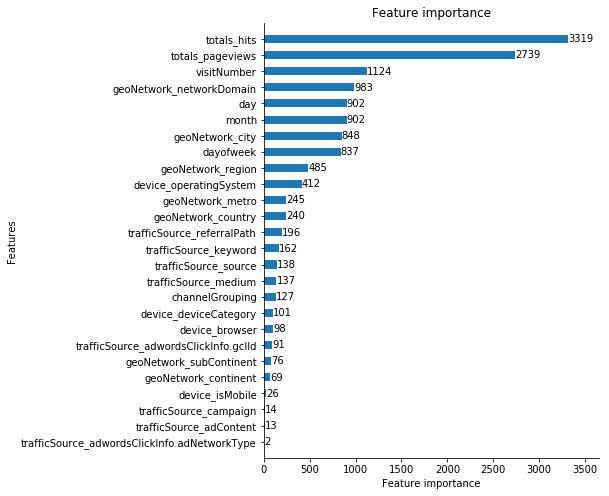

In [66]:
fig, ax = plt.subplots(figsize=(6,8))
lgb.plot_importance(model, height=0.5, ax=ax)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()